In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
from scipy.stats import pearsonr
from scipy.optimize import minimize
import random
import math

## Network

In [2]:
nw_path = "Oregon_router_networks/"
G = []
for i in range(len([x for x in os.listdir(nw_path) if x.startswith("nw")])):
    G.append(nx.read_edgelist(nw_path + os.listdir(nw_path)[i], nodetype=int))
    print("Network", i+1, "has", G[i].number_of_nodes(), "nodes and", G[i].number_of_edges(), "edges.")

Network 1 has 10670 nodes and 22002 edges.
Network 2 has 10729 nodes and 21999 edges.
Network 3 has 10790 nodes and 22469 edges.
Network 4 has 10859 nodes and 22747 edges.
Network 5 has 10886 nodes and 22493 edges.
Network 6 has 10943 nodes and 22607 edges.
Network 7 has 11011 nodes and 22677 edges.
Network 8 has 11051 nodes and 22724 edges.
Network 9 has 11174 nodes and 23409 edges.


In [3]:
for i in range(len(G)):
    print(f"Netwwork #{i+1}: mean degree: {2*G[i].number_of_edges() /(G[i].number_of_nodes())}, cc: {nx.transitivity(G[i])}")

Netwwork #1: mean degree: 4.124086223055295, cc: 0.009305600838358066
Netwwork #2: mean degree: 4.100848168515239, cc: 0.008531916555980935
Netwwork #3: mean degree: 4.164782205746061, cc: 0.009421164325108434
Netwwork #4: mean degree: 4.189520213647666, cc: 0.00971192397713825
Netwwork #5: mean degree: 4.132463714863127, cc: 0.008919346261709643
Netwwork #6: mean degree: 4.131773736635292, cc: 0.008851434528961366
Netwwork #7: mean degree: 4.118971937153756, cc: 0.008808491149213277
Netwwork #8: mean degree: 4.1125689982806986, cc: 0.008743533567413137
Netwwork #9: mean degree: 4.189905136925004, cc: 0.009635567225768079


We use network 9 since it has highest number of nodes, highest mean degree and clustering coeffecient

In [4]:
print("Using the last network for the analysis.")
g = G[-1]
nx.number_connected_components(g), g.number_of_nodes(), g.number_of_edges()

Using the last network for the analysis.


(1, 11174, 23409)

## Flu Data

In [5]:
path = "calibration/Fludata.csv"
df_flu = pd.read_csv(path)
df_flu.drop(columns=['Unnamed: 0'], inplace=True)
df_flu.head()

,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A not subtyped,B (Victoria),B (Yamagata),B (lineage not determined)
0,Norway,Non-sentinel,2013-40,2013-09-30,856,4,852,0,4,0,0,0,0
1,Norway,Non-sentinel,2013-41,2013-10-07,923,7,916,0,3,2,0,0,2
2,Norway,Non-sentinel,2013-42,2013-10-14,994,5,989,1,3,0,0,0,1
3,Norway,Non-sentinel,2013-43,2013-10-21,1209,3,1206,0,0,2,0,0,1
4,Norway,Non-sentinel,2013-44,2013-10-28,1074,6,1068,3,0,0,0,2,1


In [6]:
df_flu['A'] = df_flu['A (H1N1)pdm09'] + df_flu['A (H3)'] + df_flu['A not subtyped']
df_flu['B'] = df_flu['B (Victoria)'] + df_flu['B (Yamagata)'] + df_flu["B (lineage not determined)"]
df = df_flu.drop(columns=['Country area or territory', 'Surveillance site type', 'A (H1N1)pdm09', 'A (H3)', 'A not subtyped', 'B (Victoria)', 'B (Yamagata)', "B (lineage not determined)"])
df.head()

,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A,B
0,2013-40,2013-09-30,856,4,852,4,0
1,2013-41,2013-10-07,923,7,916,5,2
2,2013-42,2013-10-14,994,5,989,4,1
3,2013-43,2013-10-21,1209,3,1206,2,1
4,2013-44,2013-10-28,1074,6,1068,3,3


In [7]:
df["Year"] = df["Year-week (ISO 8601 calendar)"].apply(lambda x: int(x.split("-")[0]))
df["Week"] = df["Year-week (ISO 8601 calendar)"].apply(lambda x: int(x.split("-")[1]))
df.drop(columns=["Year-week (ISO 8601 calendar)", "Week start date (ISO 8601 calendar)"], inplace=True)
df.rename(columns={"Specimen tested": "S", "A":"I_A", "B":"I_B"}, inplace=True)
df = df[["Year", "Week", "S", "I_A", "I_B"]]
df.head()

,Year,Week,S,I_A,I_B
0,2013,40,856,4,0
1,2013,41,923,5,2
2,2013,42,994,4,1
3,2013,43,1209,2,1
4,2013,44,1074,3,3


In [8]:
df["S"].value_counts()

S
0       131
1        33
2        16
3        16
8        13
       ... 
35        1
33        1
458       1
446       1
1074      1
Name: count, Length: 449, dtype: int64

[John Micael Gran, et. al](https://pmc.ncbi.nlm.nih.gov/articles/PMC4634244/) estimate the Influenze related deaths in each season from 1998-1999 to 2010-2011. This had around 3.7 deaths per 100,000 population on average across the seasons. We use the same mortality rate for this analysis but for 2013-2014 to 2018-2019 seasons due to unavailability of data for these seasons.

In [9]:
df["num_sensors"] = df["S"]
df["S"] = df[["S","I_A", "I_B"]].apply(lambda x: int((x[0]-x[1]-x[2])), axis=1)

# Deaths is a fraction of the sum of the infected
df["D"] = [abs(x) for x in np.random.normal(loc=3.7/10**5, scale=0.1, size=len(df))]
df["D"] = df[["I_A","I_B", "D"]].apply(lambda x: int((x[0]+x[1])*x[2]), axis=1)
df.head()

/tmp/ipykernel_216491/1935041565.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["S"] = df[["S","I_A", "I_B"]].apply(lambda x: int((x[0]-x[1]-x[2])), axis=1)
/tmp/ipykernel_216491/1935041565.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["D"] = df[["I_A","I_B", "D"]].apply(lambda x: int((x[0]+x[1])*x[2]), axis=1)


,Year,Week,S,I_A,I_B,num_sensors,D
0,2013,40,852,4,0,856,0
1,2013,41,916,5,2,923,0
2,2013,42,989,4,1,994,0
3,2013,43,1206,2,1,1209,0
4,2013,44,1068,3,3,1074,0


In [10]:
df["num_sensors"] = df[["S","I_A","I_B","D"]].apply(lambda x: int(sum(x)), axis=1)
df.head()

,Year,Week,S,I_A,I_B,num_sensors,D
0,2013,40,852,4,0,856,0
1,2013,41,916,5,2,923,0
2,2013,42,989,4,1,994,0
3,2013,43,1206,2,1,1209,0
4,2013,44,1068,3,3,1074,0


In [11]:
df.describe()

,Year,Week,S,I_A,I_B,num_sensors,D
count,790.00000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,2015.51519,27.068354,1091.556962,118.344304,59.143038,1282.301266,13.256962
std,2.49951,15.417728,1583.617984,295.348580,216.665357,1948.200554,40.109717
min,2010.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.00000,14.000000,2.000000,0.000000,0.000000,4.000000,0.000000
50%,2016.00000,27.000000,252.000000,4.500000,1.000000,258.500000,0.000000
75%,2018.00000,41.000000,1562.750000,48.750000,13.000000,1845.750000,4.750000
max,2020.00000,53.000000,6700.000000,2441.000000,2283.000000,9275.000000,407.000000


<Axes: >

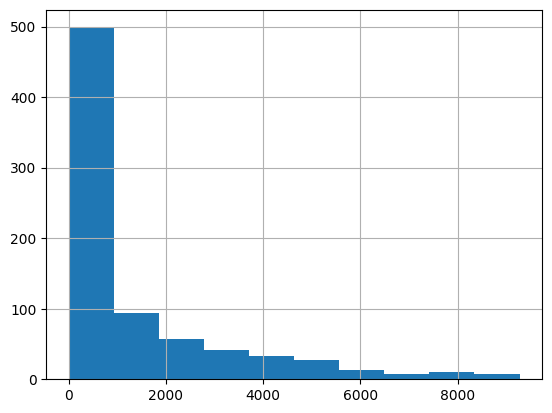

In [12]:
df["num_sensors"].hist()

In [13]:
idx_to_drop = df.index[df["num_sensors"] < 2]
len(idx_to_drop)

164

<Axes: >

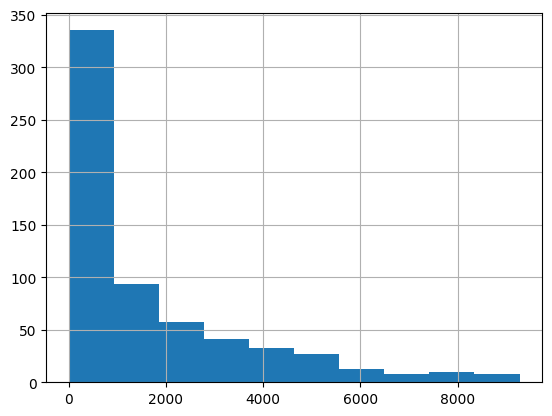

In [14]:
df1 = df.drop(index=idx_to_drop)
df1["num_sensors"].hist()

In [15]:
df1.describe()

,Year,Week,S,I_A,I_B,num_sensors,D
count,626.000000,626.000000,626.000000,626.000000,626.00000,626.000000,626.000000
mean,2015.421725,26.800319,1377.490415,149.335463,74.63099,1618.186901,16.730032
std,2.493083,16.827979,1664.764412,324.786329,241.04894,2060.847651,44.415518
min,2010.000000,1.000000,0.000000,0.000000,0.00000,2.000000,0.000000
25%,2014.000000,11.000000,12.000000,2.000000,0.00000,21.000000,0.000000
50%,2015.000000,26.000000,705.500000,10.000000,3.00000,738.000000,0.000000
75%,2018.000000,43.000000,2018.250000,104.000000,24.00000,2403.250000,9.750000
max,2020.000000,53.000000,6700.000000,2441.000000,2283.00000,9275.000000,407.000000


In [16]:
for i,row in df1.iterrows():
    if row["I_A"] + row["I_B"] < row["D"]:
        print(i)

In [17]:
l = [4,10,3]
l.remove(10)
l

[4, 3]

In [18]:
random.seed(42)

## SISD network model

In [19]:
def choose_alive_neighbor(g, node):
    neighbors = list(g.neighbors(node))
    contact = random.choice(neighbors)
    while g.nodes[contact]['state'] == 'D':
        contact = random.choice(neighbors)
    
    return contact

In [20]:
def network_SISD(N:int, params: list[float], S0:int, I0:int, num_sensors:list[int],max_time:int, full_output:bool=False):
    """Runs SISD model on a network

    Args:
        N (int): network size
        params (list[float]): epi parameters
        S0 (int): Initial susceptible
        I0 (int): Initial infected
        num_sensors (list[int]): Number of nodes to be used as sensors at each time step
        max_time (int): Number of time steps of one simulation
        full_output (bool, optional): If true returns the state of each node at each time step. Defaults to False.

    Returns:
        list: split of the compartments among the sensors at each time step
    """
    # Get parameters
    beta_1, beta_2, gamma, delta, mu = params
    pop_size = S0 + I0
    
    # Assign states
    s_nodes = random.sample(list(g.nodes()), S0*N//pop_size)
    i_nodes = list(set(g.nodes()) - set(s_nodes))
    
    for n in s_nodes:
        g.nodes[n]['state'] = 'S'
    for n in i_nodes:
        g.nodes[n]['state'] = 'Ia'

    # Accumulate nodes in different states
    S = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'S']}
    Ia = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'Ia']}
    Ib = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'Ib']}
    D = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'D']}
    # We track only for the sensors
    states = [(0, S0, I0, 0.0, 0.0)]

    # Run simulation
    for t in range(max_time-1):
        s, ia, ib, d = S[t], Ia[t], Ib[t], D[t]
        sensors = random.sample(range(N), num_sensors[t])
        for node in g.nodes():
            # Susceptible
            if g.nodes[node]['state'] == 'S':
                # Choose a random alive neighbor
                contact = choose_alive_neighbor(g, node)
                
                # S --> Ia (infected by strain A)
                if (g.nodes[contact]['state'] == 'Ia'):
                    if random.random() < beta_1:
                        g.nodes[node]['state'] = 'Ia'
                        s.remove(node)
                        ia.append(node)
                # S --> Ib (infected by strain B)
                elif (g.nodes[contact]['state'] == 'Ib'):
                    if random.random() < beta_2:
                        g.nodes[node]['state'] = 'Ib'
                        s.remove(node)
                        ib.append(node)
            
            # Strain A
            elif g.nodes[node]['state'] == 'Ia':
                # Choose a random alive neighbor
                contact = choose_alive_neighbor(g, node)
                
                # Ia --> Ib (infected by strain B)
                if (g.nodes[contact]['state'] == 'Ib'):
                    if random.random() < beta_2:
                        g.nodes[node]['state'] = 'Ib'
                        ia.remove(node)
                        ib.append(node)
                # Ia --> S (recovery)
                elif random.random() < gamma:
                    g.nodes[node]['state'] = 'S'
                    ia.remove(node)
                    s.append(node)
                # Ia --> D (death)
                elif random.random() < delta:
                    g.nodes[node]['state'] = 'D'
                    ia.remove(node)
                    d.append(node)
                # Ia --> Ib (mutation)
                elif random.random() < mu:
                    g.nodes[node]['state'] = 'Ib'
                    ia.remove(node)
                    ib.append(node)
            
            # Strain B
            elif g.nodes[node]['state'] == 'Ib':
                # Choose a random alive neighbor
                contact = choose_alive_neighbor(g, node)
                
                # Ib --> Ia (infected by strain A)
                if (g.nodes[contact]['state'] == 'Ia'):
                    if random.random() < beta_1:
                        g.nodes[node]['state'] = 'Ia'
                        ib.remove(node)
                        ia.append(node)
                # Ib --> S (recovery)
                elif random.random() < gamma:
                    g.nodes[node]['state'] = 'S'
                    ib.remove(node)
                    s.append(node)
                # Ib --> D (death)
                elif random.random() < delta:
                    g.nodes[node]['state'] = 'D'
                    ib.remove(node)
                    d.append(node)
        
        S[t+1] = list(set(s))
        Ia[t+1] = list(set(ia))
        Ib[t+1] = list(set(ib))
        D[t+1] = list(set(d))

        states.append((t+1, len(set(sensors).intersection(set(S[t+1])))/N, len(set(sensors).intersection(set(Ia[t+1])))/N,
                        len(set(sensors).intersection(set(Ib[t+1])))/N, len(set(sensors).intersection(set(D[t+1])))/N))
        
    if full_output:
        return states, {"S":S, "Ia":Ia, "Ib":Ib, "D":D}

    return states

### Calibrating

We calibrate the `beta_1`, `beta_2`, `gamma`, `delta` and `mu` using the columns `I_A` and `I_B` in our dataset

In [21]:
# Params
beta_1 = 0.08
beta_2 = 0.09
beta_3 = 0.1
gamma = 0.05
delta = 0.0001
mu = 0.00005
S0 = df1["S"][0]
I0 = df1["I_A"][0]
max_time = len(df1)
init_params = [beta_1, beta_2, gamma, delta, mu]

In [22]:
def objective(params,S0,I0,num_sensors, max_time):
    # Run simulation
    states = network_SISD(g.number_of_nodes(), params, S0, I0, num_sensors, max_time)
    print("Simulation done.")
    print(f"Timesteps: {len(states)}")
    
    # Calculate the loss
    loss = 0
    for i in range(len(states)):
        loss += (states[i][2] - df1["I_A"].values[i])**2 + (states[i][3] - df1["I_B"].values[i])**2
    
    return loss

In [ ]:
%%time
from tqdm import tqdm

# opt_sol = minimize(objective, init_params, args=(S0,I0,df1["num_sensors"],max_time), method='Nelder-Mead', options={'disp':True, 'maxiter':1000})
opt_sol = minimize(objective, init_params, args=(S0,I0,df1["num_sensors"].values.tolist(),max_time),bounds=[(0,1),(0,1),(0,1),(0,1),(0,1)])
print("Done")
b1_opt, b2_opt, g_opt, d_opt, m_opt = opt_sol.x
print(f"Optimal parameters: beta_1: {b1_opt}, beta_2: {b2_opt}, gamma: {g_opt}, delta: {d_opt}, mu: {m_opt}")

Simulation done.
Timesteps: 626
Simulation done.
Timesteps: 626
